# ARIMA

ARIMA stands for **autoregressive integrated moving average** and has three components:

1. The autoregressive (AR) component with order $p$ is defined as,

\begin{align*}
    y_t &= c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \varepsilon_t \\
    &= c + \sum_{i=1}^{p} \phi_i y_{t-i} + \varepsilon_t 
\end{align*}

2. The moving average (MA) component with order $q$ is defined as,

\begin{align*}
    y_t &= c + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \cdots + \theta_q \varepsilon_{t-q} + \varepsilon_t \\
    &= c + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i} + \varepsilon_t 
\end{align*}

3. The order of integration (I) $d$ is the number of first differencing required before the series becomes stationary. 

Note: `d` is usually \[0,1,2]

Thus, ARIMA models are defined by three parameters $(p,d,q)$ and can be written as,

\begin{align*}
    y_t' &= c + \sum_{i=1}^{p} \phi_i y_{t-i}' + \sum_{i=1}^{q} \theta_i \varepsilon_{t-i} + \varepsilon_t 
\end{align*}

where $y_t'$ is the $d$-differenced series.

The predictors in a ARIMA model are the lagged values of $y_t$ and the lagged errors.

## Forecasting Using ARIMA

Let's use ARIMA to forecast the `champagne` dataset (Makridakis and Wheelwright 1989).

The dataset provides the number of monthly sales of champagne for the Perrin Freres label (named for a region in France) from January 1964 to September 1972, or just under 10 years of data. The values are a count in **millions of sales** with a total of 105 observations. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.read_csv('champagne.csv', index_col=0).iloc[:-2,-1]

Month
1964-01    2815.0
1964-02    2672.0
1964-03    2755.0
1964-04    2721.0
1964-05    2946.0
            ...  
1972-05    4618.0
1972-06    5312.0
1972-07    4298.0
1972-08    1413.0
1972-09    5877.0
Name: Perrin Freres monthly champagne sales millions ?64-?72, Length: 105, dtype: float64

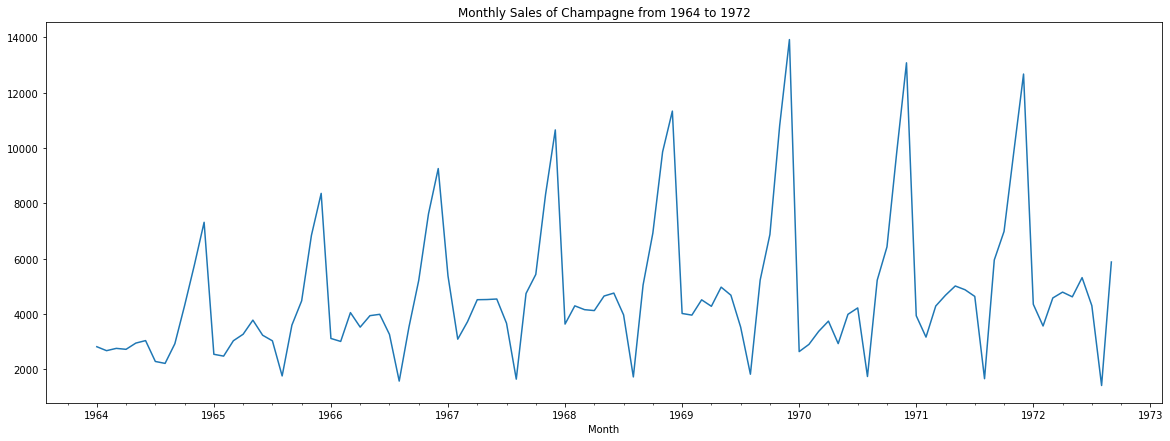

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,7)
df = pd.read_csv('champagne.csv', index_col=0).iloc[:-2,-1]
df.index = pd.PeriodIndex(df.index, dtype='period[M]')
# df.rename(columns={'Perrin Freres monthly champagne sales millions ?64-?72': 'Sales'})
df
ts_champ = df

ax = ts_champ.plot()
ax.autoscale()
ax.set_title('Monthly Sales of Champagne from 1964 to 1972')
plt.show()

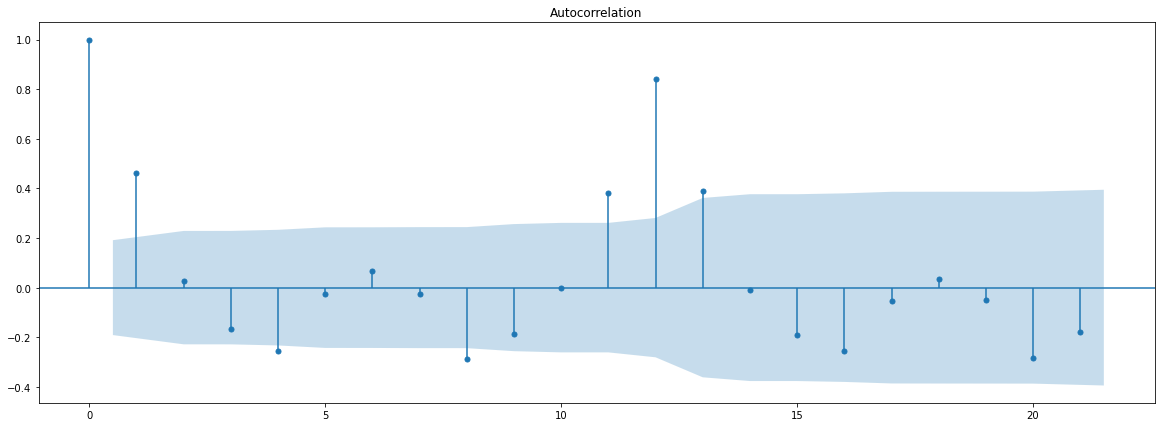

In [3]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(ts_champ) # can specify zero=False, lags=180 . check docu
plt.show()

In [4]:
df.shape

(105,)

By looking at the ACF, `m=12`

In [5]:
df_pivot = ts_champ.copy()
df_pivot.name = 'Sales'
df_pivot = df_pivot.to_frame()
df_pivot['Month'] = ts_champ.index.month
df_pivot['Year'] = ts_champ.index.year
df_pivot = df_pivot.pivot(index='Month', columns='Year', values='Sales')
df_pivot

Year,1964,1965,1966,1967,1968,1969,1970,1971,1972
Month,,,,,,,,,
1,2815.0,2541.0,3113.0,5375.0,3633.0,4016.0,2639.0,3934.0,4348.0
2,2672.0,2475.0,3006.0,3088.0,4292.0,3957.0,2899.0,3162.0,3564.0
3,2755.0,3031.0,4047.0,3718.0,4154.0,4510.0,3370.0,4286.0,4577.0
4,2721.0,3266.0,3523.0,4514.0,4121.0,4276.0,3740.0,4676.0,4788.0
5,2946.0,3776.0,3937.0,4520.0,4647.0,4968.0,2927.0,5010.0,4618.0
6,3036.0,3230.0,3986.0,4539.0,4753.0,4677.0,3986.0,4874.0,5312.0
7,2282.0,3028.0,3260.0,3663.0,3965.0,3523.0,4217.0,4633.0,4298.0
8,2212.0,1759.0,1573.0,1643.0,1723.0,1821.0,1738.0,1659.0,1413.0
9,2922.0,3595.0,3528.0,4739.0,5048.0,5222.0,5221.0,5951.0,5877.0


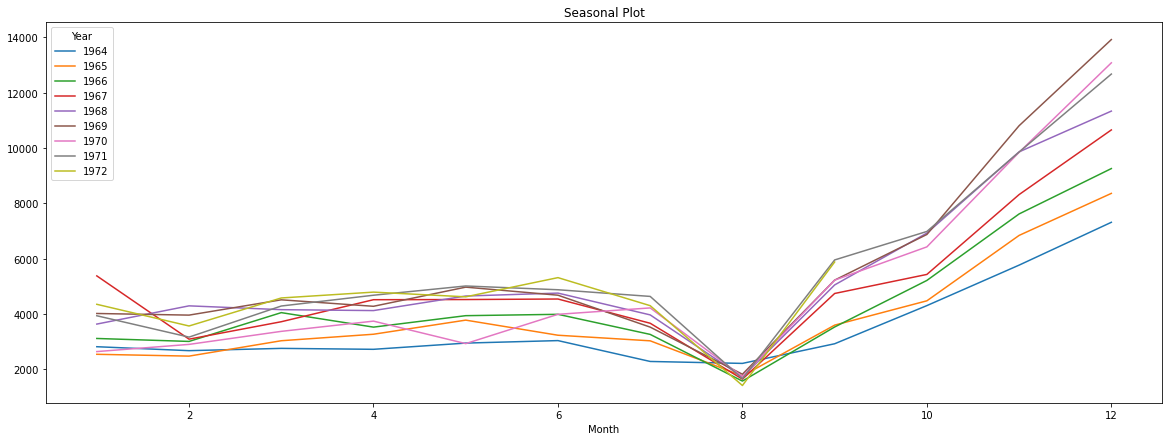

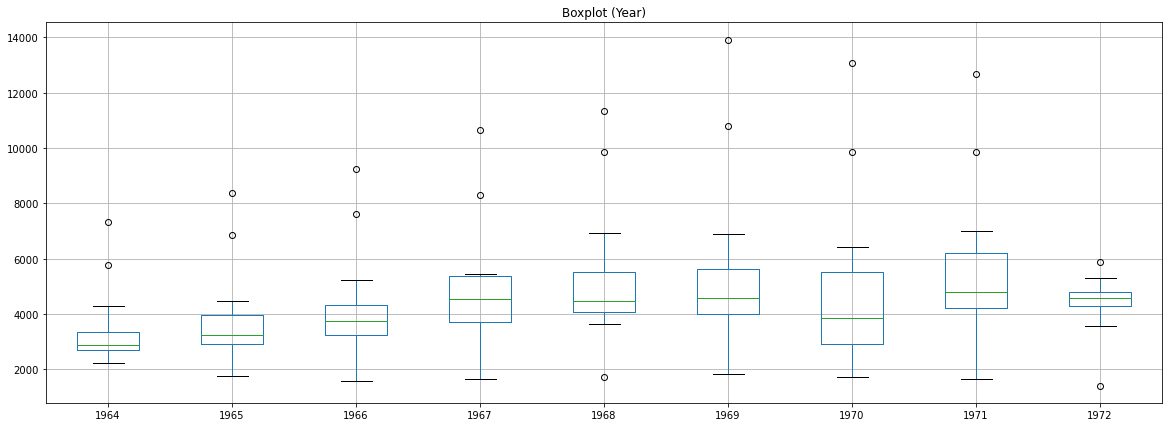

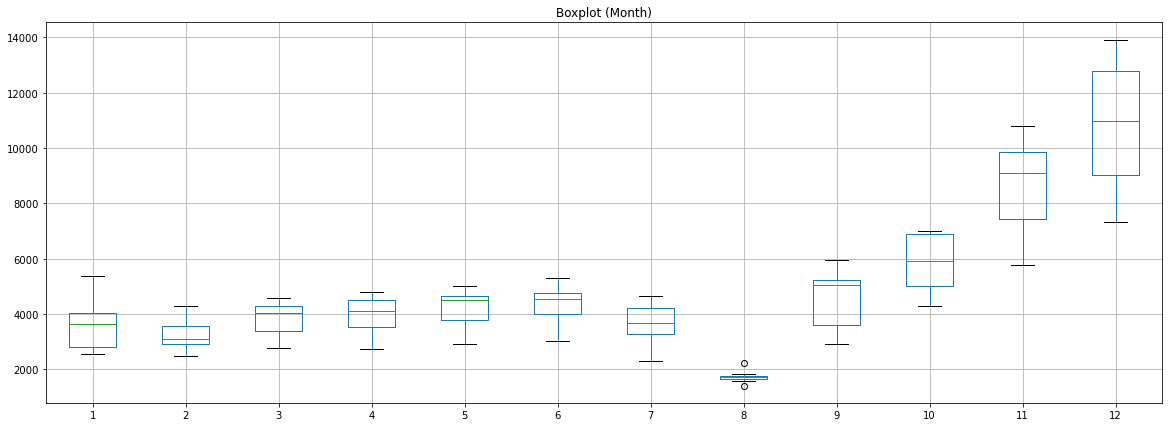

In [6]:
ax = df_pivot.plot()
ax.set_title('Seasonal Plot')
plt.show()

ax = df_pivot.boxplot()
ax.set_title('Boxplot (Year)')
plt.show()

ax = df_pivot.T.boxplot()
ax.set_title('Boxplot (Month)')
plt.show()

### 0. Defining the Objective

Once again, we need to define the use case of our forecasting model clearly. The structure of your forecasting pipeline will change depending on what the objective is.

For this example, suppose that we are interested in building a model that can be used to `generate 6-month ahead forecasts`.

### 1. Checking for stationarity

Since we've already done the stationary checks and differencing in the previous notebook, we'll expedite this step.

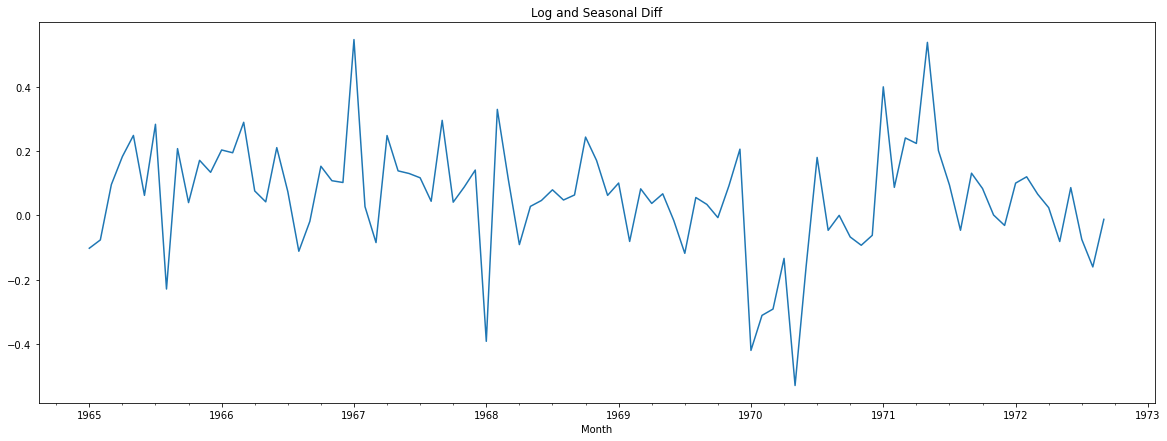

ADF = -3.617321
p-value = 0.005438
Critical Values:
	1%: -3.505
	5%: -2.894
	10%: -2.584


In [7]:
def adf_test(ts):
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(ts)
    print('ADF = %f' % res[0])
    print('p-value = %f' % res[1])
    print('Critical Values:')
    for k, v in res[4].items():
        print('\t%s: %.3f' % (k, v))
        
m = 12
ts_d = np.log(ts_champ).diff(m)[m:]

ax = ts_d.plot()
ax.autoscale()
ax.set_title('Log and Seasonal Diff')
plt.show()

adf_test(ts_d)

In [8]:
ts_champ.shape

(105,)

In [9]:
ts_d.shape

(93,)

### 2. Train-Test split

Let's create a test set by holding out the last 6 observations.

In [10]:
# prediction horizon
h = 6
test_size = 6

ts_train = ts_champ[:-test_size]
ts_test = ts_champ[-test_size:]

In [11]:
ts_train

Month
1964-01     2815.0
1964-02     2672.0
1964-03     2755.0
1964-04     2721.0
1964-05     2946.0
            ...   
1971-11     9851.0
1971-12    12670.0
1972-01     4348.0
1972-02     3564.0
1972-03     4577.0
Freq: M, Name: Perrin Freres monthly champagne sales millions ?64-?72, Length: 99, dtype: float64

In [12]:
ts_test

Month
1972-04    4788.0
1972-05    4618.0
1972-06    5312.0
1972-07    4298.0
1972-08    1413.0
1972-09    5877.0
Freq: M, Name: Perrin Freres monthly champagne sales millions ?64-?72, dtype: float64

Next, we'll apply the transformations on the training set.

<AxesSubplot:xlabel='Month'>

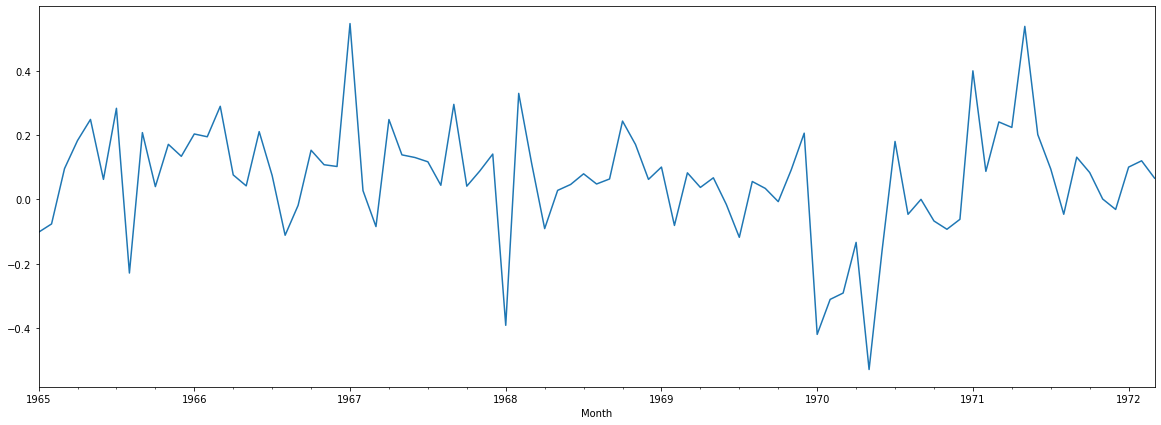

In [13]:
m = 12
ts_d = np.log(ts_train).diff(m)[m:] # Log and Seasonal Differencing (we need to reverse these transformations on the forecasts later)
ts_d.plot()

*Important note: It is recommended to perform the train-val/test split BEFORE applying the transformations. This is especially important when performing CV.*

### 3. Fitting an ARIMA model

Let's try fitting an [`ARIMA`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) model on our training set.

For the moment, lets try fitting an $\text{ARIMA}(1,0,1)$ and generating a 6-month forecast.

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(ts_d, order=(1,0,1)).fit()
y_pred = model.forecast(h)
y_pred # these are in logged differences, need to reverse back to millions of sales

C:\Users\JG\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


1972-04    0.067671
1972-05    0.066355
1972-06    0.065319
1972-07    0.064503
1972-08    0.063860
1972-09    0.063354
Freq: M, Name: predicted_mean, dtype: float64

In [15]:
ts_train[-m:]

Month
1971-04     4676.0
1971-05     5010.0
1971-06     4874.0
1971-07     4633.0
1971-08     1659.0
1971-09     5951.0
1971-10     6981.0
1971-11     9851.0
1971-12    12670.0
1972-01     4348.0
1972-02     3564.0
1972-03     4577.0
Freq: M, Name: Perrin Freres monthly champagne sales millions ?64-?72, dtype: float64

Let's reverse all the transformations we did before evaluating these predictions against our test set.

In [16]:
np.log(ts_train[-m:-m+h])

Month
1971-04    8.450198
1971-05    8.519191
1971-06    8.491670
1971-07    8.440960
1971-08    7.413970
1971-09    8.691315
Freq: M, Name: Perrin Freres monthly champagne sales millions ?64-?72, dtype: float64

In [17]:
forecast = np.exp(np.log(ts_train[-m:-m+h]).to_numpy() + y_pred.to_numpy()) 
# last year's months + y_pred to reverse the 12 month differencing performed
# and then reverse the log using np.exp
forecast

array([5003.38186183, 5353.71554174, 5202.99025623, 4941.68870093,
       1768.39957585, 6340.21843979])

In [18]:
df_f = pd.DataFrame()
df_f['Actual'] = ts_test
df_f['Forecast'] = forecast
df_f

,Actual,Forecast
Month,,
1972-04,4788.0,5003.381862
1972-05,4618.0,5353.715542
1972-06,5312.0,5202.990256
1972-07,4298.0,4941.688701
1972-08,1413.0,1768.399576
1972-09,5877.0,6340.218440


In [19]:
ts_champ.name = 'Sales'

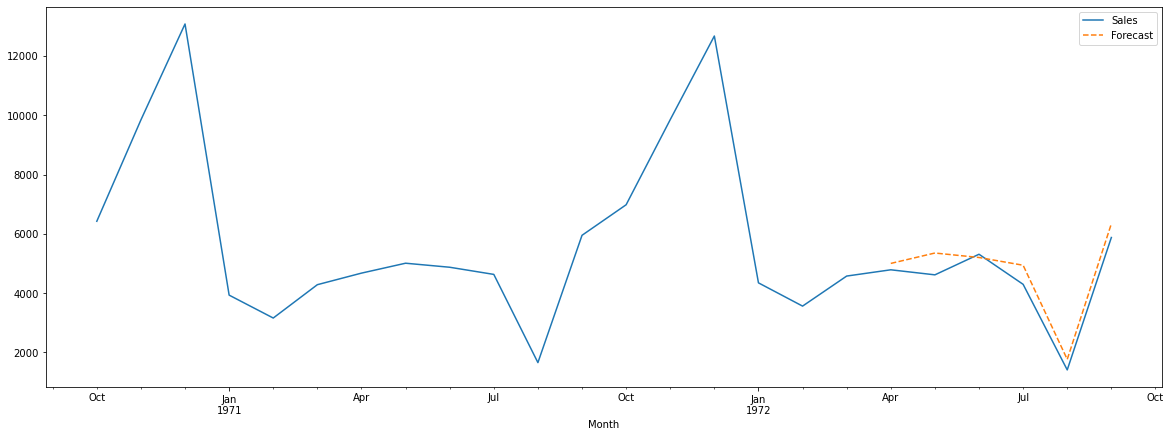

In [20]:
ax = ts_champ[-24:].plot()
df_f['Forecast'].plot(ax=ax, linestyle='--')
plt.autoscale()
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error

print('MAE =', mean_absolute_error(df_f['Actual'], df_f['Forecast']).round(2))

MAE = 420.4


We are off by 420 Millions of bottles, which is still quite a lot of money that we are losing.

<i>Note: 1 bottle = PHP $90,000$</i>

### 4. Selecting $(p,d,q)$ with grid search cross-validation

To select $(p,d,q)$, we can use grid search and optimize some metric (e.g. MAE, RMSE, etc).

In this section, we'll perform cross-validation using the `sklearn.model_selection.TimeSeriesSplit` method.

In [22]:
from sklearn.model_selection import TimeSeriesSplit

tskfold = TimeSeriesSplit(n_splits=5, test_size=h)

for train_index, val_index in tskfold.split(ts_train):
    print("Val Index:", val_index)

Val Index: [69 70 71 72 73 74]
Val Index: [75 76 77 78 79 80]
Val Index: [81 82 83 84 85 86]
Val Index: [87 88 89 90 91 92]
Val Index: [93 94 95 96 97 98]


In [23]:
import itertools
import warnings

warnings.filterwarnings("ignore") # Suppress warnings (not always a good idea)

# 6-step forecast
h = 6 
# monthly seasonality
m = 12

p_grid = range(4)
d_grid = range(2)
q_grid = range(4)
pdq_grid = list(itertools.product(p_grid, d_grid, q_grid))

df_results = pd.DataFrame()
df_results['(p,d,q)'] = pdq_grid
avg_mae = []
for pdq in pdq_grid:
    print(pdq) # swap this out for tqdm
    mae = []
    for train_index, val_index in tskfold.split(ts_train):
        
        # train-val split
        x_train = ts_train[train_index]
        y_val = ts_train[val_index]
        
        # log, s.diff
        x_d = np.log(x_train).diff(m)[m:] 
        
        # fit ARIMA
        model = ARIMA(x_d, order=pdq).fit()
        
        # forecast
        y_pred = model.forecast(h)
        
        # reverse log, s.diff
        y_pred = np.exp(np.log(x_train[-m:-m+h]).to_numpy() + y_pred.to_numpy())
        
        # compile error
        mae.append(mean_absolute_error(y_val, y_pred))
        
    # avg error
    avg_mae.append(np.mean(mae))

(0, 0, 0)
(0, 0, 1)
(0, 0, 2)
(0, 0, 3)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 1, 3)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 0, 3)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 1, 3)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 0, 3)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 1, 3)
(3, 0, 0)
(3, 0, 1)
(3, 0, 2)
(3, 0, 3)
(3, 1, 0)
(3, 1, 1)
(3, 1, 2)
(3, 1, 3)


In [24]:
df_results['Avg. MAE'] = avg_mae
df_results.sort_values(by='Avg. MAE')

,"(p,d,q)",Avg. MAE
27,"(3, 0, 3)",662.275665
29,"(3, 1, 1)",662.651977
30,"(3, 1, 2)",665.908306
15,"(1, 1, 3)",674.719185
17,"(2, 0, 1)",690.241415
10,"(1, 0, 2)",693.454915
9,"(1, 0, 1)",700.428510
21,"(2, 1, 1)",723.451986
24,"(3, 0, 0)",725.303009
25,"(3, 0, 1)",727.975581


### 5. Evaluating our ARIMA model

Now that we've selected our $(p,d,q)$, let's retrain our model on the entire training set and evaluate it against the test set.

In [25]:
ts_d = np.log(ts_train).diff(m)[m:] 

model = ARIMA(ts_d, order=(3,0,3)).fit()
y_pred = model.forecast(h)
y_pred = np.exp(np.log(ts_train[-m:-m+h]).to_numpy() + y_pred.to_numpy())

df_f = pd.DataFrame()
df_f['Actual'] = ts_test
df_f['Forecast'] = y_pred
df_f

,Actual,Forecast
Month,,
1972-04,4788.0,4739.698718
1972-05,4618.0,5086.122838
1972-06,5312.0,5245.170990
1972-07,4298.0,5140.297660
1972-08,1413.0,1777.283515
1972-09,5877.0,6094.636767


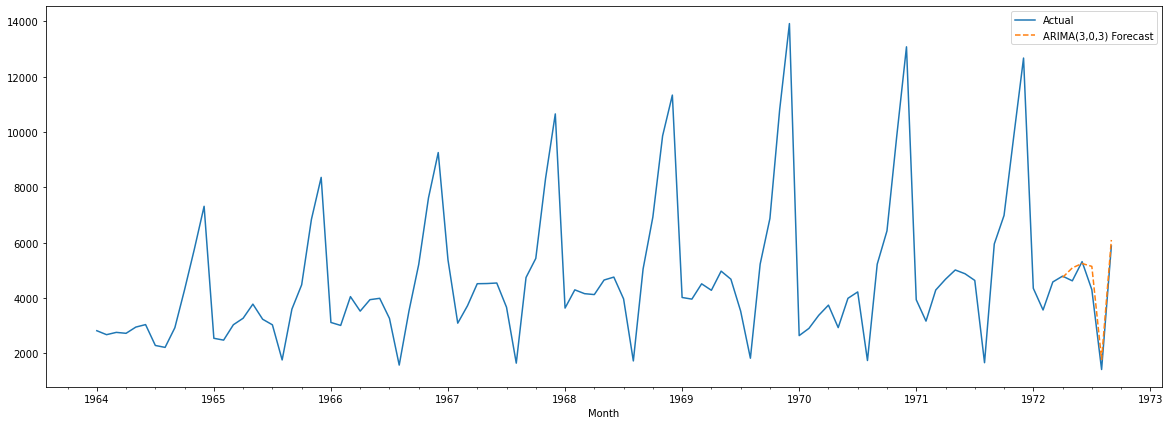

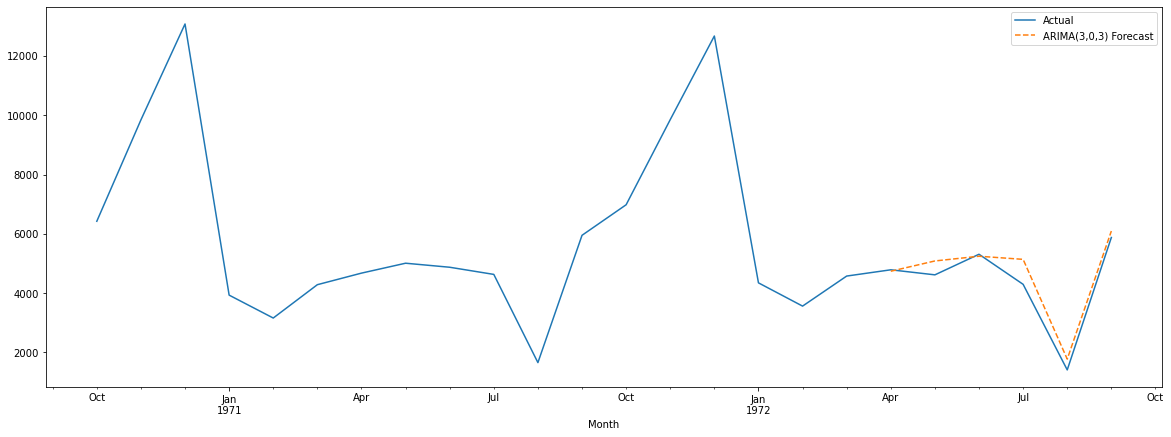

In [26]:
ax = ts_champ.plot()
df_f['Forecast'].plot(ax=ax, linestyle='--')
plt.autoscale()
plt.legend(['Actual', 'ARIMA(3,0,3) Forecast'])
plt.show()

ax = ts_champ[-24:].plot()
df_f['Forecast'].plot(ax=ax, linestyle='--')
plt.autoscale()
plt.legend(['Actual', 'ARIMA(3,0,3) Forecast'])
plt.show()

In [27]:
print('MAE =', mean_absolute_error(df_f['Actual'], df_f['Forecast']))

MAE = 334.57851204516095


### 6. Adding baselines forecasts

As a final step, let's add some baseline forecasts.

In [28]:
df_f['Naive'] = np.repeat(ts_train[-1], h)
df_f['S.Naive'] = ts_train[-m:-m+h].to_numpy()
df_f

,Actual,Forecast,Naive,S.Naive
Month,,,,
1972-04,4788.0,4739.698718,4577.0,4676.0
1972-05,4618.0,5086.122838,4577.0,5010.0
1972-06,5312.0,5245.170990,4577.0,4874.0
1972-07,4298.0,5140.297660,4577.0,4633.0
1972-08,1413.0,1777.283515,4577.0,1659.0
1972-09,5877.0,6094.636767,4577.0,5951.0


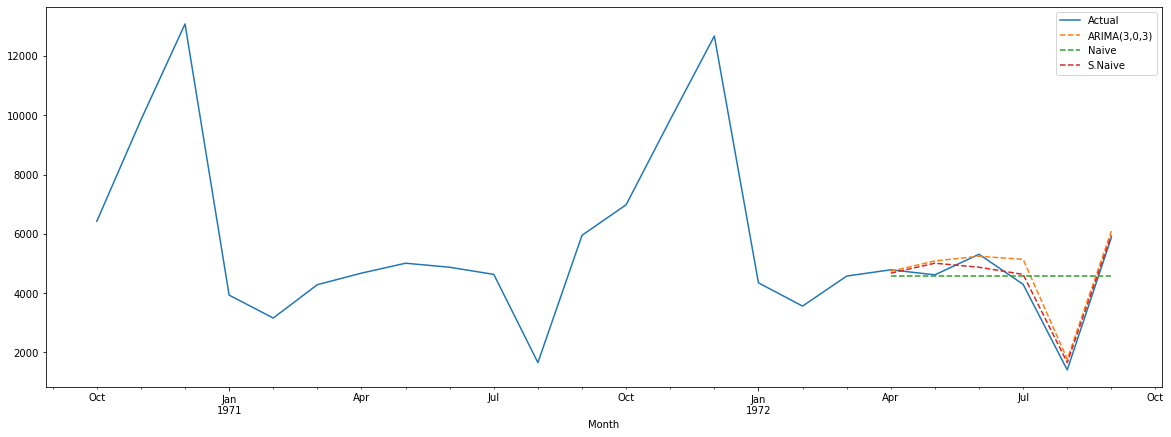

  ARIMA MAE = 334.58
  Naive MAE = 955.0
S.Naive MAE = 266.17


In [29]:
ax = ts_champ[-24:].plot()
df_f['Forecast'].plot(ax=ax, linestyle='--')
df_f['Naive'].plot(ax=ax, linestyle='--')
df_f['S.Naive'].plot(ax=ax, linestyle='--')
plt.autoscale()
plt.legend(['Actual', 'ARIMA(3,0,3)', 'Naive', 'S.Naive'])
plt.show()

print('  ARIMA MAE =', mean_absolute_error(df_f['Actual'], df_f['Forecast']).round(2))
print('  Naive MAE =', mean_absolute_error(df_f['Actual'], df_f['Naive']).round(2))
print('S.Naive MAE =', mean_absolute_error(df_f['Actual'], df_f['S.Naive']).round(2))

### 7. Why did S.Naive beat ARIMA?

Was there a bug in our code? Something wrong with the methodology?

In [30]:
# 6-step forecast
h = 6 
# monthly seasonality
m = 12

# Best params
pdq = (3, 0, 3)

errors = {'ARIMA': [], 'S.Naive': []}
for train_index, val_index in tskfold.split(ts_train):

    # train-val split
    x_train = ts_champ[train_index]
    y_val = ts_champ[val_index]

    # log, s.diff
    x_d = np.log(x_train).diff(m)[m:] 

    # fit ARIMA
    model = ARIMA(x_d, order=pdq).fit()

    # forecast
    y_pred = model.forecast(h)

    # reverse log, s.diff
    y_pred = np.exp(np.log(x_train[-m:-m+h]).to_numpy() + y_pred.to_numpy())

    # compile error
    errors['ARIMA'].append(mean_absolute_error(y_val, y_pred))
    errors['S.Naive'].append(mean_absolute_error(y_val, x_train[-m:-m+h]))

In [33]:
ts_train.shape

(99,)

In [34]:
ts_champ.shape

(105,)

In [31]:
for train_index, val_index in tskfold.split(ts_train):
    print('train= ', train_index)
    print('val= ', val_index)

train=  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
val=  [69 70 71 72 73 74]
train=  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74]
val=  [75 76 77 78 79 80]
train=  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80]
val=  [81 82 83 84 85 86]
train=  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 

In [32]:
# avg error
print('  ARIMA Avg. MAE =', np.mean(errors['ARIMA']).round(2))
print('S.Naive Avg. MAE =', np.mean(errors['S.Naive']).round(2))

  ARIMA Avg. MAE = 662.28
S.Naive Avg. MAE = 771.17


## Exercises

1. Create a function that can apply $d$ differencing, given a time series.

2. Create a function that can reverse the $d$ differencing (useful for reversing the difference of forecasts).

## Big Picture Goals

1. Create your own `AutoARIMA` pipeline.

2. Create your own `AutoTS` pipeline.